# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'autoencoder'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341736.000000,341736.000000,3.417360e+05,3.417360e+05,3.417360e+05
mean,3297.084510,284.493392,1.616547e-08,1.729086e-10,4.172296e+01
std,1787.420224,12.444296,3.040603e-06,3.160590e-08,3.824214e+01
min,80.215370,249.496434,0.000000e+00,0.000000e+00,1.585317e-14
25%,1488.666795,274.942441,0.000000e+00,0.000000e+00,2.442180e+00
50%,3605.163780,287.485713,0.000000e+00,0.000000e+00,3.064934e+01
75%,4902.021024,295.257689,9.039629e-36,2.611568e-37,8.628855e+01
max,6862.129388,304.725510,1.481370e-03,1.521341e-05,9.474959e+01


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.0719342990219593
Training Loss: 0.0635237079486251
Training Loss: 0.061360132675617934
Validation Loss: 0.05678389690230402
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05841772835701704
Training Loss: 0.0549566319398582
Training Loss: 0.05275600956752896
Validation Loss: 0.048152995976002026
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04905602604150772
Training Loss: 0.04619405403733254
Training Loss: 0.04387080520391464
Validation Loss: 0.03952448515828406
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03986457142047584
Training Loss: 0.0375639587175101
Training Loss: 0.03568467869888991
Validation Loss: 0.031900350548578114
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.031836231080815194
Training Loss: 0.03000017470214516
Training Loss

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive_evaluation.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [02:48<25:15, 168.34s/it]

Training Loss: 0.006102306378888898
Validation Loss: 0.0030701279736992516
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1960234024003148
Training Loss: 0.15055579356849194
Training Loss: 0.11524049840867519
Validation Loss: 0.08566978958885321
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07851921280846
Training Loss: 0.06685358513146639
Training Loss: 0.06047527257353067
Validation Loss: 0.0543512280486273
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056507172398269176
Training Loss: 0.052838707063347104
Training Loss: 0.050147944642230866
Validation Loss: 0.044544925808571695
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04630113396793604
Training Loss: 0.043543134722858666
Training Loss: 0.04111975227482617
Validation Loss: 0.036389146000146866
Validation Accur

 20%|██        | 2/10 [05:35<22:18, 167.35s/it]

Training Loss: 0.006308512630057521
Validation Loss: 0.0033927346923744326
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 1.0810271653532981
Training Loss: 0.912328594326973
Training Loss: 0.7448511782288552
Validation Loss: 0.5997206578763683
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.5260554423928261
Training Loss: 0.43703488141298297
Training Loss: 0.33768784269690516
Validation Loss: 0.23938201384597949
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.19980413429439067
Training Loss: 0.14478559374809266
Training Loss: 0.09895120991393924
Validation Loss: 0.06756428424059675
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06939219443127513
Training Loss: 0.0663937089778483
Training Loss: 0.06332129014655948
Validation Loss: 0.05507119408065683
Validation Accuracy: 0.0

 30%|███       | 3/10 [08:20<19:25, 166.46s/it]

Training Loss: 0.006211148205329664
Validation Loss: 0.003273558150192074
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5362894174456596
Training Loss: 0.4636016502976418
Training Loss: 0.3757849528640509
Validation Loss: 0.28473693182629145
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.23229267328977585
Training Loss: 0.16030794464051723
Training Loss: 0.10221408886834979
Validation Loss: 0.07003142249383283
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07166520230472088
Training Loss: 0.06883429054170848
Training Loss: 0.06682783888652921
Validation Loss: 0.06154480496986529
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06523837147280574
Training Loss: 0.06379338417202235
Training Loss: 0.06224498968571424
Validation Loss: 0.057375168867325514
Validation Accuracy:

 40%|████      | 4/10 [11:05<16:36, 166.01s/it]

Training Loss: 0.005257667936966755
Validation Loss: 0.0022514998949436323
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0720229454524815
Training Loss: 0.06950870456174016
Training Loss: 0.06903346074745059
Validation Loss: 0.06551810006579656
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06846964007243514
Training Loss: 0.06595952913165093
Training Loss: 0.0650968523696065
Validation Loss: 0.06094756889879034
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06336871027946472
Training Loss: 0.06047672288492322
Training Loss: 0.05877788232639432
Validation Loss: 0.05379940452200643
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05543142322450876
Training Loss: 0.0522832920588553
Training Loss: 0.04986467469483614
Validation Loss: 0.0446055175297046
Validation Accuracy: 

 50%|█████     | 5/10 [13:50<13:48, 165.69s/it]

Training Loss: 0.006245101595995947
Validation Loss: 0.0032491121896322857
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5153505375981331
Training Loss: 0.38692076317965984
Training Loss: 0.25504035033285616
Validation Loss: 0.13885535668121296
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09930962909013033
Training Loss: 0.06727747982367874
Training Loss: 0.055259958319365976
Validation Loss: 0.04895407423963038
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0501620027795434
Training Loss: 0.049065156057476994
Training Loss: 0.046903819805011154
Validation Loss: 0.042482636617810536
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04336720762774348
Training Loss: 0.04215734739787877
Training Loss: 0.04031487435102463
Validation Loss: 0.03640286523974343
Validation Accu

 60%|██████    | 6/10 [16:35<11:01, 165.46s/it]

Training Loss: 0.0057036267220973965
Validation Loss: 0.0027365994213274522
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06895782969892025
Training Loss: 0.06426746627315878
Training Loss: 0.06209154043346644
Validation Loss: 0.057297155386611315
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0579315516166389
Training Loss: 0.053424871433526276
Training Loss: 0.05004691790789366
Validation Loss: 0.04316215660799755
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043237438602373
Training Loss: 0.03886386755853891
Training Loss: 0.03593382926657796
Validation Loss: 0.030598080570527007
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03077262074686587
Training Loss: 0.02870340050663799
Training Loss: 0.027589881708845496
Validation Loss: 0.023939984745942475
Validation Acc

 70%|███████   | 7/10 [19:15<08:10, 163.45s/it]

Training Loss: 0.006376791633083485
Validation Loss: 0.0033496061099295535
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08961160823702813
Training Loss: 0.0737932194955647
Training Loss: 0.061770816259086134
Validation Loss: 0.05354216665531812
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054558842573314906
Training Loss: 0.051297968234866854
Training Loss: 0.04891451532952487
Validation Loss: 0.04425750618402877
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04498438113369048
Training Loss: 0.041863755714148285
Training Loss: 0.03954037427902222
Validation Loss: 0.03497782267964958
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.035438252575695516
Training Loss: 0.0328289938531816
Training Loss: 0.03092229422647506
Validation Loss: 0.02643317345194937
Validation Acc

 80%|████████  | 8/10 [21:54<05:24, 162.06s/it]

Training Loss: 0.00625137155642733
Validation Loss: 0.003296370230866282
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09635010059922934
Training Loss: 0.07153422806411981
Training Loss: 0.05906679449602961
Validation Loss: 0.05427338459183661
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054728797543793915
Training Loss: 0.05121261693537235
Training Loss: 0.049551859525963665
Validation Loss: 0.04638132308557462
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04651752768084407
Training Loss: 0.043666647151112556
Training Loss: 0.04213213060982526
Validation Loss: 0.03924402965002515
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03901543889194727
Training Loss: 0.03682782275602221
Training Loss: 0.035555387269705536
Validation Loss: 0.032842055737469976
Validation Acc

 90%|█████████ | 9/10 [24:34<02:41, 161.44s/it]

Training Loss: 0.0059434698679251595
Validation Loss: 0.002930904687591567
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.36247110813856126
Training Loss: 0.2918331404030323
Training Loss: 0.1941326030343771
Validation Loss: 0.10699968684590265
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09468477610498667
Training Loss: 0.07284276317805052
Training Loss: 0.06416909364983439
Validation Loss: 0.059727682826224336
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061928443498909476
Training Loss: 0.05976699523627758
Training Loss: 0.0595607478171587
Validation Loss: 0.05747399654950988
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05921734208241105
Training Loss: 0.05698710188269615
Training Loss: 0.05664027940481901
Validation Loss: 0.0544273243861252
Validation Accuracy

100%|██████████| 10/10 [27:13<00:00, 163.37s/it]


Training Loss: 0.00565915375831537
Validation Loss: 0.0028804048851362608
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.341328784301877
Training Loss: 0.2680811931937933
Training Loss: 0.2148016309738159
Validation Loss: 0.1755485175951813
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1550519696623087
Training Loss: 0.1271864702180028
Training Loss: 0.10560609785839915
Validation Loss: 0.08806621544900235
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0813782599940896
Training Loss: 0.0752377924695611
Training Loss: 0.07443058982491493
Validation Loss: 0.07374232678852055
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07127336723729968
Training Loss: 0.06975652826949955
Training Loss: 0.07007693599909544
Validation Loss: 0.0694644239134668
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.06710237564519048
Training Loss: 0.06556961350142956
Training Loss: 0.065666

 10%|█         | 1/10 [02:45<24:50, 165.60s/it]

Epoch: 1
Training Loss: 0.10245638435706496
Training Loss: 0.08744596736505628
Training Loss: 0.08310858769342304
Validation Loss: 0.08091618223220445
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07761885941028596
Training Loss: 0.07515162663534283
Training Loss: 0.07485307946801185
Validation Loss: 0.0735919408165337
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07065488362684846
Training Loss: 0.06843370832502842
Training Loss: 0.06791937636211515
Validation Loss: 0.06627368912351934
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06343656219542027
Training Loss: 0.060944876046851275
Training Loss: 0.05975001530721784
Validation Loss: 0.05748043586029095
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.054886167142540215
Training Loss: 0.052303221458569166
Training Lo

 20%|██        | 2/10 [05:31<22:06, 165.83s/it]

Epoch: 1
Training Loss: 0.34439481638371944
Training Loss: 0.2531050527840853
Training Loss: 0.16475820854306222
Validation Loss: 0.10039139901068103
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08549592567607761
Training Loss: 0.06916709616780281
Training Loss: 0.06541654031723737
Validation Loss: 0.06476891808881519
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06151241356506944
Training Loss: 0.058885051906108855
Training Loss: 0.05763725088909268
Validation Loss: 0.0569867595527949
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05385977585799992
Training Loss: 0.051306615266948935
Training Loss: 0.04959415965713561
Validation Loss: 0.04853625427094403
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04573936403729022
Training Loss: 0.04329293786548078
Training Loss

 30%|███       | 3/10 [08:17<19:20, 165.76s/it]

Epoch: 1
Training Loss: 0.08131779167801141
Training Loss: 0.0735383148305118
Training Loss: 0.07095110230147839
Validation Loss: 0.06852157610688317
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06569128643721342
Training Loss: 0.06328066512942314
Training Loss: 0.062131978627294304
Validation Loss: 0.05896773199770558
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056270060706883666
Training Loss: 0.052895214129239324
Training Loss: 0.050382176116108894
Validation Loss: 0.04612871591169178
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043753042314201594
Training Loss: 0.04050678718835116
Training Loss: 0.03792852806858718
Validation Loss: 0.03496765091052551
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03351964789442718
Training Loss: 0.03178455704823136
Training 

 40%|████      | 4/10 [11:02<16:34, 165.72s/it]

Epoch: 1
Training Loss: 0.07212217174470424
Training Loss: 0.06769886566326022
Training Loss: 0.0654400734230876
Validation Loss: 0.06290923490115766
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05900657087564468
Training Loss: 0.05577398458495736
Training Loss: 0.053084517884999516
Validation Loss: 0.050199489538254365
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.046847687745466826
Training Loss: 0.04352088422514498
Training Loss: 0.040298779122531415
Validation Loss: 0.037331450908455285
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03497441723011434
Training Loss: 0.032359792245551945
Training Loss: 0.02955923198722303
Validation Loss: 0.027324812785000277
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.025994389783591032
Training Loss: 0.024438054324127732
Train

 50%|█████     | 5/10 [13:48<13:47, 165.50s/it]

Epoch: 1
Training Loss: 0.23539066523313523
Training Loss: 0.16670348230749368
Training Loss: 0.11617107389494777
Validation Loss: 0.08323394557398357
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07198283372446895
Training Loss: 0.06171682054176927
Training Loss: 0.058902442697435616
Validation Loss: 0.05840679682958662
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05586181883700192
Training Loss: 0.05426198909990489
Training Loss: 0.053374388497322796
Validation Loss: 0.051999374575326954
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049367902567610145
Training Loss: 0.04683574739843607
Training Loss: 0.0444610442686826
Validation Loss: 0.04086117655708549
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03858897285535932
Training Loss: 0.0358651474211365
Training Lo

 60%|██████    | 6/10 [16:33<11:01, 165.47s/it]

Training Loss: 0.006195651120506227
Validation Loss: 0.0034459080927079187
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07194067640230059
Training Loss: 0.06880595883354544
Training Loss: 0.06747898794710636
Validation Loss: 0.06382643272367756
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06114550951868296
Training Loss: 0.05824290808290243
Training Loss: 0.05670254921540618
Validation Loss: 0.052749716059378025
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05068835071288049
Training Loss: 0.04780442714691162
Training Loss: 0.04596494991332292
Validation Loss: 0.04214195546097635
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04071321739815176
Training Loss: 0.03838049582205713
Training Loss: 0.0366260960046202
Validation Loss: 0.03360732223085138
Validation Accura

 70%|███████   | 7/10 [19:18<08:16, 165.39s/it]

Training Loss: 0.00632226080109831
Validation Loss: 0.003525209430673191
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.43707421749830244
Training Loss: 0.3480840372294188
Training Loss: 0.27594859190285204
Validation Loss: 0.22221049423632996
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.19433610066771506
Training Loss: 0.15526517909020185
Training Loss: 0.12034747252240777
Validation Loss: 0.09593073977680688
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08463488344103098
Training Loss: 0.07401826009154319
Training Loss: 0.0695737761631608
Validation Loss: 0.06743316387946016
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06472381830215454
Training Loss: 0.06366441173478961
Training Loss: 0.06437101162970066
Validation Loss: 0.06411089047036145
Validation Accuracy: 

 80%|████████  | 8/10 [22:03<05:30, 165.08s/it]

Training Loss: 0.00733584591303952
Validation Loss: 0.004421500744182993
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.9283220592141151
Training Loss: 0.7868858522176743
Training Loss: 0.6430950184166432
Validation Loss: 0.4900389492846607
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.40924672670662404
Training Loss: 0.2648446511477232
Training Loss: 0.15672870373353362
Validation Loss: 0.10025066120570965
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08788069127127528
Training Loss: 0.07489199435338378
Training Loss: 0.07101907374337316
Validation Loss: 0.07084000376419405
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06819866506382823
Training Loss: 0.06683692496269941
Training Loss: 0.06655739603564143
Validation Loss: 0.06711382450263821
Validation Accuracy: 0.0

 90%|█████████ | 9/10 [24:47<02:44, 164.72s/it]

Training Loss: 0.007229300939361565
Validation Loss: 0.0044131311986940714
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0797421263344586
Training Loss: 0.07130946427583694
Training Loss: 0.0684397729113698
Validation Loss: 0.06558319693954473
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06304196294397116
Training Loss: 0.059891212312504646
Training Loss: 0.05781175699084997
Validation Loss: 0.05365231439596816
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051165803410112856
Training Loss: 0.04761078180745244
Training Loss: 0.04484063166193664
Validation Loss: 0.040705715107281555
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03911037906073034
Training Loss: 0.03663496104069054
Training Loss: 0.03435631398111582
Validation Loss: 0.031038342655918906
Validation Accu

100%|██████████| 10/10 [27:30<00:00, 165.08s/it]

Training Loss: 0.006725813446682878
Validation Loss: 0.003972040399061411
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.0627760969940573
Training Loss: 0.05706595492549241
Training Loss: 0.05887867816723883
Validation Loss: 0.05850764094025231
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05361316786380485
Training Loss: 0.05095759623683989
Training Loss: 0.051880825515836476
Validation Loss: 0.05077459825349323
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04628518706565956
Training Loss: 0.04317127753049135
Training Loss: 0.043179560881108046
Validation Loss: 0.0408908881540044
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03667048311044709
Training Loss: 0.03288527135271579
Training Loss: 0.03193600509315729
Validation Loss: 0.02931406357838364
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.026012422349012923
Training Loss: 0.022978602015646176
Training Lo

 10%|█         | 1/10 [02:45<24:45, 165.01s/it]

Training Loss: 6.6186455683237e-05
Validation Loss: 6.573018656249434e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 1.1505508744716644
Training Loss: 0.9787634193897248
Training Loss: 0.8875461289286614
Validation Loss: 0.7401187229022551
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.6892381206154823
Training Loss: 0.5042048855125905
Training Loss: 0.41070101961493494
Validation Loss: 0.28590976245952454
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.2417770617455244
Training Loss: 0.13251292389817537
Training Loss: 0.09516553922556341
Validation Loss: 0.06836470218082324
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06237485088407993
Training Loss: 0.0532420214638114
Training Loss: 0.05542455205693841
Validation Loss: 0.054467112895917526
Validation Accuracy: 0.0


 20%|██        | 2/10 [05:29<21:59, 164.94s/it]

Training Loss: 5.220108843786875e-05
Validation Loss: 4.6877880756736056e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.05624039774294943
Training Loss: 0.05287403292953968
Training Loss: 0.052795739183202385
Validation Loss: 0.05086331287126863
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04681315686015296
Training Loss: 0.042811727514490486
Training Loss: 0.04186260835267604
Validation Loss: 0.0392372303621404
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.035672242584987544
Training Loss: 0.03185114427004009
Training Loss: 0.030961197158321737
Validation Loss: 0.02843031987778089
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.025594382384151685
Training Loss: 0.022335508397081868
Training Loss: 0.021567007785197347
Validation Loss: 0.019548563790256473
Validati

 30%|███       | 3/10 [08:14<19:13, 164.84s/it]

Training Loss: 8.237958149948099e-05
Validation Loss: 7.990622320443783e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.20377265453338622
Training Loss: 0.13799452035687865
Training Loss: 0.10353555104695261
Validation Loss: 0.0735063809519529
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06347346276044846
Training Loss: 0.04906620632391423
Training Loss: 0.04841481762006879
Validation Loss: 0.04596502810005057
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04362061141408049
Training Loss: 0.04130352220032364
Training Loss: 0.043051974484696984
Validation Loss: 0.04184953700960352
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03956407546356786
Training Loss: 0.03752135589485988
Training Loss: 0.038813442764803766
Validation Loss: 0.037494704231954695
Validation Acc

 40%|████      | 4/10 [10:59<16:29, 164.84s/it]

Training Loss: 5.894254235954577e-05
Validation Loss: 5.630490748730705e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2765535578876734
Training Loss: 0.22264875808730722
Training Loss: 0.1897242865897715
Validation Loss: 0.15383503029353163
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.132941326322034
Training Loss: 0.09457583582727239
Training Loss: 0.07495585599448532
Validation Loss: 0.0674184158109547
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06414244934916496
Training Loss: 0.060086315777152774
Training Loss: 0.06120301418937743
Validation Loss: 0.059961920583181165
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05763149412814528
Training Loss: 0.053601436391472815
Training Loss: 0.05446599853225052
Validation Loss: 0.052518731338924235
Validation Accura

 50%|█████     | 5/10 [13:44<13:44, 164.84s/it]

Training Loss: 5.4411286455433583e-05
Validation Loss: 5.172670310794989e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08679446347989142
Training Loss: 0.062148230550810694
Training Loss: 0.05416979468427598
Validation Loss: 0.04840357971032349
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0454436281931703
Training Loss: 0.041362116332165896
Training Loss: 0.04086785283870995
Validation Loss: 0.03765799363635564
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03494641516066622
Training Loss: 0.030103001943789422
Training Loss: 0.028068980192765592
Validation Loss: 0.024770345863247854
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02227893491566647
Training Loss: 0.018423414940480144
Training Loss: 0.017649669516831636
Validation Loss: 0.017257230798452254
Validati

 60%|██████    | 6/10 [16:29<10:59, 164.90s/it]

Training Loss: 4.957993152402196e-05
Validation Loss: 4.8024380102913384e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07878328057006001
Training Loss: 0.06431394014507533
Training Loss: 0.06423304142430425
Validation Loss: 0.061365289765336874
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05809483962133527
Training Loss: 0.05423202433623373
Training Loss: 0.055953782573342326
Validation Loss: 0.054336363177620965
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05121149893500842
Training Loss: 0.046996098165400325
Training Loss: 0.04671314957551658
Validation Loss: 0.0428220292741663
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.039147894655470736
Training Loss: 0.03351807865779847
Training Loss: 0.03167391950264573
Validation Loss: 0.027486305144939865
Validation

 70%|███████   | 7/10 [19:14<08:15, 165.00s/it]

Training Loss: 6.13129826660952e-05
Validation Loss: 5.5969877434967036e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7042978066205978
Training Loss: 0.5782892543077469
Training Loss: 0.4939495345950127
Validation Loss: 0.38331667317098445
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3390457335859537
Training Loss: 0.22947800943627952
Training Loss: 0.16307349674403668
Validation Loss: 0.09407939597587572
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07667032016441226
Training Loss: 0.05001186589244753
Training Loss: 0.050157600110396744
Validation Loss: 0.04852438284858559
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04496158786932938
Training Loss: 0.04339090627618134
Training Loss: 0.04523047796450555
Validation Loss: 0.04517550276738874
Validation Accuracy

 80%|████████  | 8/10 [21:59<05:29, 164.89s/it]

Training Loss: 6.364802428379334e-05
Validation Loss: 6.79893439456883e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6968565268814564
Training Loss: 0.5798141965270043
Training Loss: 0.5012702536582947
Validation Loss: 0.3900374328152517
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3414638928323984
Training Loss: 0.2209382758103311
Training Loss: 0.1470062374137342
Validation Loss: 0.09041080803851063
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07971489554736763
Training Loss: 0.06773072538431733
Training Loss: 0.07020721285603941
Validation Loss: 0.06813829329408956
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06478839334820805
Training Loss: 0.06113692422397435
Training Loss: 0.06340787495486438
Validation Loss: 0.062031327568915454
Validation Accuracy: 0.

 90%|█████████ | 9/10 [24:43<02:44, 164.83s/it]

Training Loss: 5.4424780728368205e-05
Validation Loss: 4.898333249554291e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06919193436391652
Training Loss: 0.05756871404126287
Training Loss: 0.05855183326639235
Validation Loss: 0.05757315959153551
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05327856707153842
Training Loss: 0.05010557202622294
Training Loss: 0.050523621663451194
Validation Loss: 0.049172887222820455
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.044546404705906754
Training Loss: 0.041103602023795247
Training Loss: 0.04090988933574408
Validation Loss: 0.0394511488501736
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03482768772151758
Training Loss: 0.0315487348753959
Training Loss: 0.03123574677621946
Validation Loss: 0.03031571584706603
Validation Ac

100%|██████████| 10/10 [27:28<00:00, 164.86s/it]

Training Loss: 7.147644920223684e-05
Validation Loss: 7.000686148305168e-05
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.06978943359106779
Training Loss: 0.0661557544581592
Training Loss: 0.06757592832669616
Training Loss: 0.05518961646360367
Training Loss: 0.04440140910446644
Training Loss: 0.0428295665467158
Training Loss: 0.04228525188751519
Validation Loss: 0.0469670496699627
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059441961832344535
Training Loss: 0.05530195351690054
Training Loss: 0.05621614959090948
Training Loss: 0.04359690850309562
Training Loss: 0.032466872348450124
Training Loss: 0.030495928609743716
Training Loss: 0.028711296506226062
Validation Loss: 0.03250449430546287
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04310145361348987
Training Loss: 0.0384316913690418
Training Loss: 0.037846540221944454
Training Loss: 0.0243384635826078
Training Loss: 0.011057147938990965
Training Loss: 0.008956932696746663
Training Loss: 0.007082471245375928
Validatio

 10%|█         | 1/10 [05:28<49:15, 328.33s/it]

Training Loss: 0.00028533658976812146
Validation Loss: 0.0014512589889576777
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5588678543269634
Training Loss: 0.4176759772002697
Training Loss: 0.3126830043643713
Training Loss: 0.1852132278122008
Training Loss: 0.11249553125351668
Training Loss: 0.06258263343945146
Training Loss: 0.04895012062042951
Validation Loss: 0.05405933768331502
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06571760043501854
Training Loss: 0.06334975085221231
Training Loss: 0.06465270597487688
Training Loss: 0.05433763213222846
Training Loss: 0.04128197102807462
Training Loss: 0.039490250153467056
Training Loss: 0.04207648435607553
Validation Loss: 0.048185495489664124
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05849123952910304
Training Loss: 0.056095432732254265
Training Loss: 0.05726929880678654


 20%|██        | 2/10 [08:03<30:13, 226.68s/it]

Training Loss: 0.0006465234189818147
Validation Loss: 0.0019161759858056274
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 95
Early stopping after 95 epochs
Epoch: 1
Training Loss: 0.36863405972719193
Training Loss: 0.23896637320518493
Training Loss: 0.13507011281326414
Training Loss: 0.06565211715509577
Training Loss: 0.04179083911934867
Training Loss: 0.040455262535251675
Training Loss: 0.03801882883068174
Validation Loss: 0.042429892824132565
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.056414232645183804
Training Loss: 0.05165698319673538
Training Loss: 0.052903056079521775
Training Loss: 0.038174719323869795
Training Loss: 0.027937928319443018
Training Loss: 0.025425625850912185
Training Loss: 0.023559572065714747
Validation Loss: 0.027434751213517752
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03928908842615783
Training Loss: 0.03495268263854

 30%|███       | 3/10 [13:31<31:50, 272.91s/it]

Training Loss: 0.0004066894998686621
Validation Loss: 0.0014071488350848684
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.40340090438723564
Training Loss: 0.28563844427466395
Training Loss: 0.1840191350504756
Training Loss: 0.09161145444959402
Training Loss: 0.06006519767455756
Training Loss: 0.05810229816008359
Training Loss: 0.053692703740671276
Validation Loss: 0.058927074814222276
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07214189918711782
Training Loss: 0.06724125996232033
Training Loss: 0.06910334710031747
Training Loss: 0.05535948883742094
Training Loss: 0.04366017796564847
Training Loss: 0.043121303669177
Training Loss: 0.04229261429980397
Validation Loss: 0.04746535977816091
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058964370097965
Training Loss: 0.05518189297057688
Training Loss: 0.0567978460714221
Trai

 40%|████      | 4/10 [18:59<29:26, 294.44s/it]

Training Loss: 0.0003514593853651604
Validation Loss: 0.0014582381817071406
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07621978988870978
Training Loss: 0.07105740441009402
Training Loss: 0.0694634405709803
Training Loss: 0.05522912046093552
Training Loss: 0.04295025422237814
Training Loss: 0.038887353874742986
Training Loss: 0.03822975110262632
Validation Loss: 0.04333005620215493
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05505141951143742
Training Loss: 0.05053169519640505
Training Loss: 0.049364453721791504
Training Loss: 0.03314892051432253
Training Loss: 0.01687221980886534
Training Loss: 0.010994120622053743
Training Loss: 0.007325667917029932
Validation Loss: 0.017311522138936355
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03045674261637032
Training Loss: 0.02746184727642685
Training Loss: 0.02825250599998

 50%|█████     | 5/10 [21:25<20:04, 240.88s/it]

Training Loss: 0.0002515230745120789
Validation Loss: 0.0016856989031646676
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 89
Early stopping after 89 epochs
Epoch: 1
Training Loss: 0.6112840621173382
Training Loss: 0.4947100985050201
Training Loss: 0.4143149594962597
Training Loss: 0.30687703609466555
Training Loss: 0.22689191952347756
Training Loss: 0.16653689239174127
Training Loss: 0.12571119068190456
Validation Loss: 0.11469381966729289
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1284304264932871
Training Loss: 0.09889775233343244
Training Loss: 0.0835433305054903
Training Loss: 0.06088326443452388
Training Loss: 0.04663784626871347
Training Loss: 0.04465099426917732
Training Loss: 0.046445059040561315
Validation Loss: 0.05204479708528139
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06375653309747577
Training Loss: 0.060727984663099054
Training

 60%|██████    | 6/10 [26:51<17:59, 269.79s/it]

Training Loss: 0.00038123394213471326
Validation Loss: 0.0014128794072610972
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08493820317089558
Training Loss: 0.07213870776817202
Training Loss: 0.06952017514035105
Training Loss: 0.0546452848133049
Training Loss: 0.043188923825509845
Training Loss: 0.040037571908906104
Training Loss: 0.03954119394067675
Validation Loss: 0.044387539454530014
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05772126642987132
Training Loss: 0.05292658835649491
Training Loss: 0.05321525614708662
Training Loss: 0.038788017149781806
Training Loss: 0.027493163417093455
Training Loss: 0.02460356317460537
Training Loss: 0.02334538655122742
Validation Loss: 0.028640902128544976
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04080406446941197
Training Loss: 0.03692777414806187
Training Loss: 0.037630067095

 70%|███████   | 7/10 [28:22<10:34, 211.35s/it]

Training Loss: 0.0006184922678221482
Validation Loss: 0.0019324390119123047
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 56
Early stopping after 56 epochs
Epoch: 1
Training Loss: 0.22080556105822324
Training Loss: 0.1633672910183668
Training Loss: 0.12700927902013062
Training Loss: 0.08512092366814614
Training Loss: 0.06501541835255921
Training Loss: 0.05782722551375628
Training Loss: 0.0578621269762516
Validation Loss: 0.0627408479078767
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07572074113413692
Training Loss: 0.07218998715281487
Training Loss: 0.07305544482544064
Training Loss: 0.0624107860843651
Training Loss: 0.050755324261263016
Training Loss: 0.048906888095661995
Training Loss: 0.05004480479285121
Validation Loss: 0.054913779211401496
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06675702754408121
Training Loss: 0.06387417130172253
Traini

 80%|████████  | 8/10 [33:47<08:15, 247.54s/it]

Training Loss: 0.0003837108253719634
Validation Loss: 0.0013841365731961342
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3942133964598179
Training Loss: 0.2908069333434105
Training Loss: 0.1986486577987671
Training Loss: 0.10822698028758168
Training Loss: 0.06177026790101081
Training Loss: 0.05081727468874306
Training Loss: 0.04754016877152026
Validation Loss: 0.05317506106912197
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06560870064422489
Training Loss: 0.06161469130776823
Training Loss: 0.06314331140369177
Training Loss: 0.05166033487268578
Training Loss: 0.04013766553252936
Training Loss: 0.03858045341446996
Training Loss: 0.04001660724636167
Validation Loss: 0.04529313591730952
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05643675073981285
Training Loss: 0.0532592296320945
Training Loss: 0.05451976159587502
Trai

 90%|█████████ | 9/10 [38:06<04:11, 251.12s/it]

Training Loss: 0.0005452731301193126
Validation Loss: 0.0016939309955952158
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 160
Early stopping after 160 epochs
Epoch: 1
Training Loss: 0.31693657994270324
Training Loss: 0.23504751972854138
Training Loss: 0.15367101345211268
Training Loss: 0.0823291930463165
Training Loss: 0.05163943718187511
Training Loss: 0.04688932637218386
Training Loss: 0.04821998117491603
Validation Loss: 0.054400233551859856
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06721562052145601
Training Loss: 0.06474679116159678
Training Loss: 0.06581425769254565
Training Loss: 0.05438641950720921
Training Loss: 0.042785234292969106
Training Loss: 0.040782106262631714
Training Loss: 0.04184572142548859
Validation Loss: 0.04799003652139996
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060428211819380524
Training Loss: 0.05810429779812694


100%|██████████| 10/10 [43:28<00:00, 260.84s/it]

Training Loss: 0.0005720329424366354
Validation Loss: 0.0016260126650648205
Validation Accuracy: 0.0
**************************************************


In [10]:
results.shape

(80, 3)

In [11]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [12]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

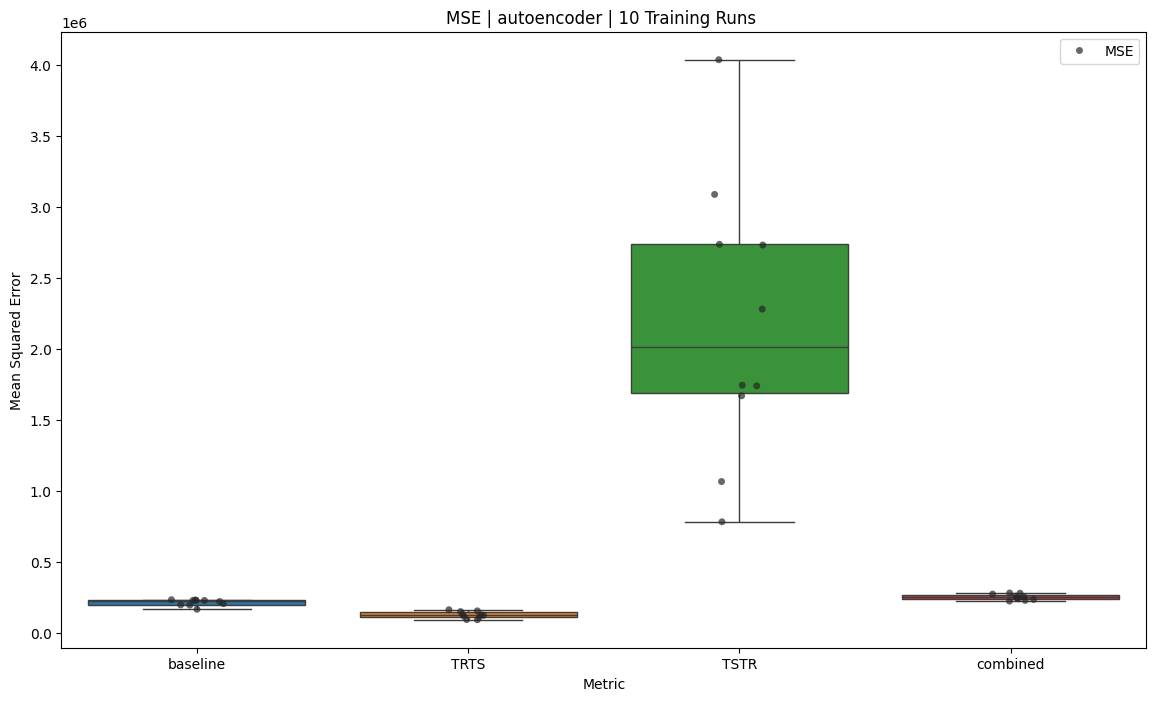

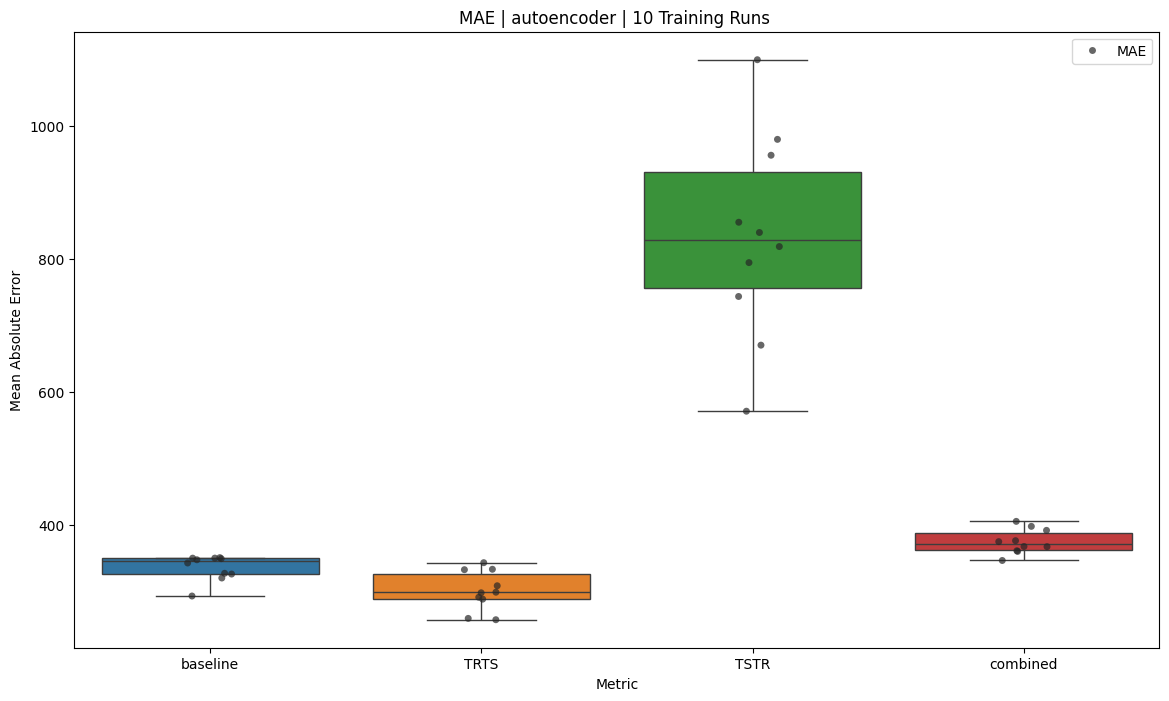

In [13]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Visualize Synthetic vs Real Data

In [14]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)


In [15]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

Preprocessing data. Shape: (28500, 12, 5)


IndexError: index 28479 is out of bounds for axis 0 with size 28478

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.